In [55]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [56]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [218]:
import os
import time

import cv2
import numpy as np
from skimage import segmentation
import math
import torch
import torch.nn as nn
from torch.nn.modules.batchnorm import _BatchNorm
import torch.nn.functional as F
from scipy.io import loadmat,savemat
from unet_model import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
mark_boundaries = segmentation.mark_boundaries

In [219]:
def denormalizeimage(images, mean=(0., 0., 0.), std=(1., 1., 1.)):
    """Denormalize tensor images with mean and standard deviation.
    Args:
        images (tensor): N*C*H*W
        mean (tuple): means for each channel.
        std (tuple): standard deviations for each channel.
    """
    images = images.cpu().numpy()
    # N*C*H*W to N*H*W*C
    images = images.transpose((0,2,3,1))
    images *= std
    images += mean
    images *=255.0
    # N*H*W*C to N*C*H*W
    images = images.transpose((0,3,1,2))
    return torch.tensor(images)


In [220]:
class UNet(nn.Module):
    def __init__(self, inp_dim, mod_dim1, mod_dim2):
        super(UNet, self).__init__()
        self.inc = inconv(inp_dim, 64)
        self.down1 = down(64, 128)
        self.up4 = up(192, 128)
        self.dcs0 = DCS(128, 32, 3)
        self.outc = outconv(128, mod_dim2)
        self.dcs1 = DCS(mod_dim2, 32, 3)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x = self.up4(x2, x1)
        x = self.outc(x)
        x, mu = self.dcs1(x)
        return x

In [221]:
class DeepLab(nn.Module):
    def __init__(self, num_classes=21, backbone='resnet50'):
        super(DeepLab, self).__init__()
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            self.backbone.fc = nn.Identity()  # Remove the fully connected layer
        else:
            raise NotImplementedError("Backbone not supported")

        # Define the DeepLab head
        self.aspp = nn.Sequential(
            nn.Conv2d(2048, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=6, dilation=6),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=12, dilation=12),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.aspp(x)

        return x


In [222]:
class DCS(nn.Module):
    '''The Deep Clustering Subnetwork (DCS).
    Arguments:
        c (int): The input and output channel number.
        k (int): The number of cluster centers.
        stage_num (int): The iteration number for EM.
    '''
    ### 定义DCS网络结构
    def __init__(self, c, k, stage_num=3):
        super(DCS, self).__init__()
        self.stage_num = stage_num

        mu = torch.Tensor(1, c, k)  #
        mu.normal_(0, math.sqrt(2. / k))  #
        mu = self._l2norm(mu, dim=1)
        self.register_buffer('mu', mu)

        self.conv1 = nn.Conv2d(c, c, 1)
        self.conv2 =nn.Conv2d(c, c, 1, bias=False)

        ####iteration
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, _BatchNorm):
                m.weight.data.fill_(1)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        idn = x
        # The first 1x1 conv
        x = self.conv1(x)

        b, c, h, w = x.size()
        x = x.view(b, c, h * w)
        mu = self.mu.repeat(b, 1, 1)  # b * c * k
        with torch.no_grad():
            for i in range(self.stage_num):
                x_t = x.permute(0, 2, 1)  # b * n * c
                z = torch.bmm(x_t, mu)  # b * n * k
                z = F.softmax(z, dim=2)  # b * n * k
                z_ = z / (1e-6 + z.sum(dim=1, keepdim=True))
                mu = torch.bmm(x, z_)
                mu = self._l2norm(mu, dim=1)

        z_t = z.permute(0, 2, 1)  # b * k * n
        x = mu.matmul(z_t)  # b * c * n
        x = x.view(b, c, h, w)  # b * c * h * w
        x = F.relu(x, inplace=True)

        # The second 1x1 conv
        x = self.conv2(x)
        x = x + idn #
        x = F.relu(x, inplace=True)

        return x, mu

    def _l2norm(self, inp, dim):
        '''Normlize the inp tensor with l2-norm.

        Returns a tensor where each sub-tensor of input along the given dim is
        normalized such that the 2-norm of the sub-tensor is equal to 1.

        Arguments:
            inp (tensor): The inp
            ut tensor.
            dim (int): The dimension to slice over to get the ssub-tensors.

        Returns:
            (tensor) The normalized tensor.
        '''
        return inp / (1e-6 + inp.norm(dim=dim, keepdim=True))


In [223]:
class Args(object):
    train_epoch =100 ## training iteration T ##
    mod_dim1 = 64  #
    mod_dim2 =100 #
    gpu_id =0 #0
    min_label_num = 4  # if the label number small than it, break loop
    max_label_num = 256  # if the label number small than it, start to show result image.

In [224]:
class MyNet(nn.Module):
    def __init__(self, inp_dim, mod_dim1, mod_dim2):
        super(MyNet, self).__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(inp_dim, mod_dim1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mod_dim1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mod_dim1, mod_dim2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mod_dim2),
            nn.ReLU(inplace=True),
            nn.Conv2d(mod_dim2, mod_dim1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mod_dim1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mod_dim1, mod_dim2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mod_dim2),
        )
        self.emau = DCS(mod_dim2, 64, 3)

    def forward(self, x):
        x=self.seq(x)
        return x

In [225]:
def get_filelist(dir, Filelist):

    newDir = dir

    if os.path.isfile(dir):

        Filelist.append(dir)

    elif os.path.isdir(dir):
        for s in os.listdir(dir):
            newDir = os.path.join(dir, s)
            get_filelist(newDir, Filelist)

    return Filelist

In [226]:
def run_base(name,namep):
    start_time0 = time.time()
    args = Args()
    pathbsd='./image\\'
    torch.cuda.manual_seed_all(1943)
    np.random.seed(1943)
    os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_id)  # choose GPU:0
    input_image_path = pathbsd + name
    image = cv2.imread(input_image_path)

    softmax = nn.Softmax(dim=1)

    '''segmentation ML'''
    m = loadmat('./superpixel/'+namep+'.mat');
    seglab = m["seg_lab"]

    seg_map=seglab
    show = mark_boundaries(image, seg_map)
    seg_map = seg_map.flatten()
    seg_lab = [np.where(seg_map == u_label)[0]
               for u_label in np.unique(seg_map)]

    '''train init'''
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

    tensor = image.transpose((2, 0, 1))
    tensor = tensor.astype(np.float32) / 255.0
    tensor = tensor[np.newaxis, :, :, :]
    tensor = torch.from_numpy(tensor).to(device)
    model = UNet(inp_dim=3, mod_dim1=args.mod_dim1, mod_dim2=args.mod_dim2).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)
    image_flatten = image.reshape((-1, 3))
    color_avg = np.random.randint(255, size=(args.max_label_num, 3))
    show = image

    '''train loop'''
    start_time1 = time.time()
    model.train()
    for batch_idx in range(args.train_epoch):
        '''forward'''
        optimizer.zero_grad()
        output = model(tensor)[0]
        output1=output
        output1 = output1[np.newaxis, :, :, :]
        output2= output[0:1, :, :]
        croppings = (output2 > 0).float()

        output = output.permute(1, 2, 0).view(-1, args.mod_dim2)
        target = torch.argmax(output, 1)
        im_target = target.data.cpu().numpy()

        '''refine'''
        for inds in seg_lab:
            u_labels, hist = np.unique(im_target[inds], return_counts=True)
            im_target[inds] = u_labels[np.argmax(hist)]

        '''backward'''
        target = torch.from_numpy(im_target)
        target = target.to(device)

        loss = criterion(output, target) #as defined in Eq. (8)

        loss.backward()
        optimizer.step()

        '''show image''' #to print using the pesudo color;
        un_label, lab_inverse = np.unique(im_target, return_inverse=True, )
        if un_label.shape[0] < args.max_label_num:  # update show
            img_flatten = image_flatten.copy()
            if len(color_avg) != un_label.shape[0]:
                color_avg = [np.mean(img_flatten[im_target == label], axis=0, dtype=np.int) for label in un_label]
            for lab_id, color in enumerate(color_avg):
                img_flatten[lab_inverse == lab_id] = color
            show = img_flatten.reshape(image.shape)
        cv2.imshow("seg_pt", show)
        cv2.waitKey(1)
        print(loss.item())
        if len(un_label) < args.min_label_num:
            break

    '''save'''
    sp=list(image.shape)
    label = im_target.reshape((sp[0],sp[1]))

    time0 = time.time() - start_time0
    time1 = time.time() - start_time1

    print('PyTorchInit: %.2f\nTimeUsed: %.2f' % (time0, time1))
    cv2.imwrite("output/seg_%s_%ds.jpg" % (namep, time1), show)
    return time1



In [227]:
def run_deep(name,namep):
    start_time0 = time.time()
    args = Args()
    pathbsd='./image\\'
    torch.cuda.manual_seed_all(1943)
    np.random.seed(1943)
    os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_id)  # choose GPU:0
    
    transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # Replace with your dataset's mean and std
    ])
    
    '''train init'''
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    
    input_image_path = pathbsd + name
    image = cv2.imread(input_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    image_tensor = transform(image)
    tensor = image_tensor.unsqueeze(0).to(device)

    softmax = nn.Softmax(dim=1)

    '''segmentation ML'''
    m = loadmat('./superpixel/'+namep+'.mat');
    seglab = m["seg_lab"]

    seg_map=seglab
    show = mark_boundaries(image, seg_map)
    seg_map = seg_map.flatten()
    seg_lab = [np.where(seg_map == u_label)[0]
               for u_label in np.unique(seg_map)]



    tensor = image.transpose((2, 0, 1))
    tensor = tensor.astype(np.float32) / 255.0
    tensor = tensor[np.newaxis, :, :, :]
    tensor = torch.from_numpy(tensor).to(device)
    model = UNet(inp_dim=3, mod_dim1=args.mod_dim1, mod_dim2=args.mod_dim2).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)
    image_flatten = image.reshape((-1, 3))
    color_avg = np.random.randint(255, size=(args.max_label_num, 3))
    show = image

    '''train loop'''
    start_time1 = time.time()
    model.train()
    for batch_idx in range(args.train_epoch):
        '''forward'''
        optimizer.zero_grad()
        output = model(tensor)[0]
        output1=output
        output1 = output1[np.newaxis, :, :, :]
        output2= output[0:1, :, :]
        croppings = (output2 > 0).float()

        output = output.permute(1, 2, 0).view(-1, args.mod_dim2)
        target = torch.argmax(output, 1)
        im_target = target.data.cpu().numpy()

        '''refine'''
        for inds in seg_lab:
            u_labels, hist = np.unique(im_target[inds], return_counts=True)
            im_target[inds] = u_labels[np.argmax(hist)]

        '''backward'''
        target = torch.from_numpy(im_target)
        target = target.to(device)

        loss = criterion(output, target) #as defined in Eq. (8)

        loss.backward()
        optimizer.step()

        '''show image''' #to print using the pesudo color;
        un_label, lab_inverse = np.unique(im_target, return_inverse=True, )
        if un_label.shape[0] < args.max_label_num:  # update show
            img_flatten = image_flatten.copy()
            if len(color_avg) != un_label.shape[0]:
                color_avg = [np.mean(img_flatten[im_target == label], axis=0, dtype=np.int) for label in un_label]
            for lab_id, color in enumerate(color_avg):
                img_flatten[lab_inverse == lab_id] = color
            show = img_flatten.reshape(image.shape)
        show_transformed = transform(show)
        cv2.imshow("seg_pt", show)
        cv2.waitKey(1)
        print(loss.item())
        if len(un_label) < args.min_label_num:
            break

    '''save'''
    sp=list(image.shape)
    label = im_target.reshape((sp[0],sp[1]))

    time0 = time.time() - start_time0
    time1 = time.time() - start_time1

    print('PyTorchInit: %.2f\nTimeUsed: %.2f' % (time0, time1))
    cv2.imwrite("output/seg_%s_%ds.jpg" % (namep, time1), show)
    return time1



In [228]:
def mainBase():
    dir='./image\\'
    LIst=get_filelist(dir, [])
    print(LIst)
    ST=0
    for ii in range(len(LIst)-1):
        name=LIst[ii][8:]
        print(name)
        namep=name[:-4]
        print(namep)
        time=run_base(name,namep)
        print(time)
        ST=ST+time
    print(ST/300)

In [229]:
def mainDeep():
    dir='./image\\'
    LIst=get_filelist(dir, [])
    print(LIst)
    ST=0
    for ii in range(len(LIst)-1):
        name=LIst[ii][8:]
        print(name)
        namep=name[:-4]
        print(namep)
        #time=run_deep(name,namep)
        print(time)
        ST=ST+time
    print(ST/300)

['./image\\2092.jpg', './image\\3096.jpg']
2092.jpg
2092


C:\Users\shels\AppData\Local\Temp\ipykernel_31016\2059265030.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color_avg = [np.mean(img_flatten[im_target == label], axis=0, dtype=np.int) for label in un_label]


4.262509822845459
3.839090347290039
3.636770486831665
3.422633171081543
3.247164011001587
3.0521509647369385
2.8544580936431885
2.6364004611968994
2.411118984222412
2.1989636421203613
1.951040267944336
1.7076860666275024
1.4770587682724
1.2800732851028442
1.140665054321289
1.1237719058990479
0.9092574119567871
0.7961152195930481
0.6867005228996277
0.6016615629196167
0.5507212281227112
0.4904826283454895
0.4443718194961548
0.3963768184185028
0.3601105213165283
0.33268049359321594
0.30670806765556335
0.2860814332962036
0.2720554769039154
0.25486984848976135
0.24160578846931458
0.23048491775989532
0.21966134011745453
0.2068074345588684
0.19950538873672485
0.19238045811653137
0.1865340620279312
0.18017907440662384
0.17499543726444244
0.16787011921405792
0.16305600106716156
0.15787288546562195
0.15388992428779602
0.1487089991569519
0.14509452879428864
0.1406472772359848
0.13653837144374847
0.13331076502799988
0.12950284779071808
0.12612205743789673
0.1220865473151207
0.11756253987550735
0.1

In [252]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

def run_new(name, namep):
    pathbsd = './image/'  # Use forward slash as path separator
    torch.cuda.manual_seed_all(1943)
    np.random.seed(1943)
    os.environ['CUDA_VISIBLE_DEVICES'] = str(0)  # choose GPU:0
    input_image_path = os.path.join(pathbsd, name)  # Correctly join path components
    img = cv2.imread(input_image_path)

    b, g, r = cv2.split(img)
    rgb_img = cv2.merge([r, g, b])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Perform morphological closing operation
    kernel = np.ones((2, 2), np.uint8)  # Define a 2x2 kernel
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)  # Perform closing operation

    # Find sure background region
    sure_bg = cv2.dilate(closing, kernel, iterations=3)  

    # Display images using Matplotlib
    plt.subplot(211), plt.imshow(closing, 'gray')  
    plt.title("morphologyEx:Closing:2x2"), plt.xticks([]), plt.yticks([])
    plt.subplot(212), plt.imshow(sure_bg, 'gray')
    plt.imsave(r'dilation.png', sure_bg)
    plt.title("Dilation"), plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()




In [251]:
def mainNew():
    dir='./image\\'
    LIst=get_filelist(dir, [])
    print(LIst)
    ST=1
    for ii in range(len(LIst)-1):
        name=LIst[ii][8:]
        print(name)
        namep=name[:-4]
        print(namep)
        time=run_new(name,namep)
        print(time)
        ST=ST+time
    print(ST/300)

['./image\\2092.jpg', './image\\3096.jpg', './image\\8023.jpg', './image\\8049.jpg']
2092.jpg
2092


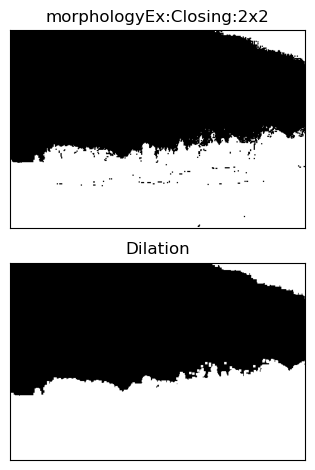

None


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [253]:
if __name__ == '__main__':
    mainNew()
    #mainDeep()

ValueError: not enough values to unpack (expected 3, got 0)

In [256]:
import os
import cv2

# Input and output directories
input_folder = 'image'
output_folder = 'output-2'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List all image files in the input folder
image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg') or f.endswith('.png')]

# Loop through each image file
for image_file in image_files:
    # Load the image
    image_path = os.path.join(input_folder, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image as grayscale

    # Perform segmentation using a simple thresholding technique
    _, segmented_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    # Save the segmented image to the output folder
    output_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_path, segmented_image)

    print(f"Segmentation completed for {image_file}.")

print("All images segmented and saved.")

Segmentation completed for 2092.jpg.
Segmentation completed for 3096.jpg.
Segmentation completed for 8023.jpg.
Segmentation completed for 8049.jpg.
All images segmented and saved.


C:\Users\shels\AppData\Local\Temp\ipykernel_31016\167733133.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\shels\AppData\Local\Temp\ipykernel_31016\167733133.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

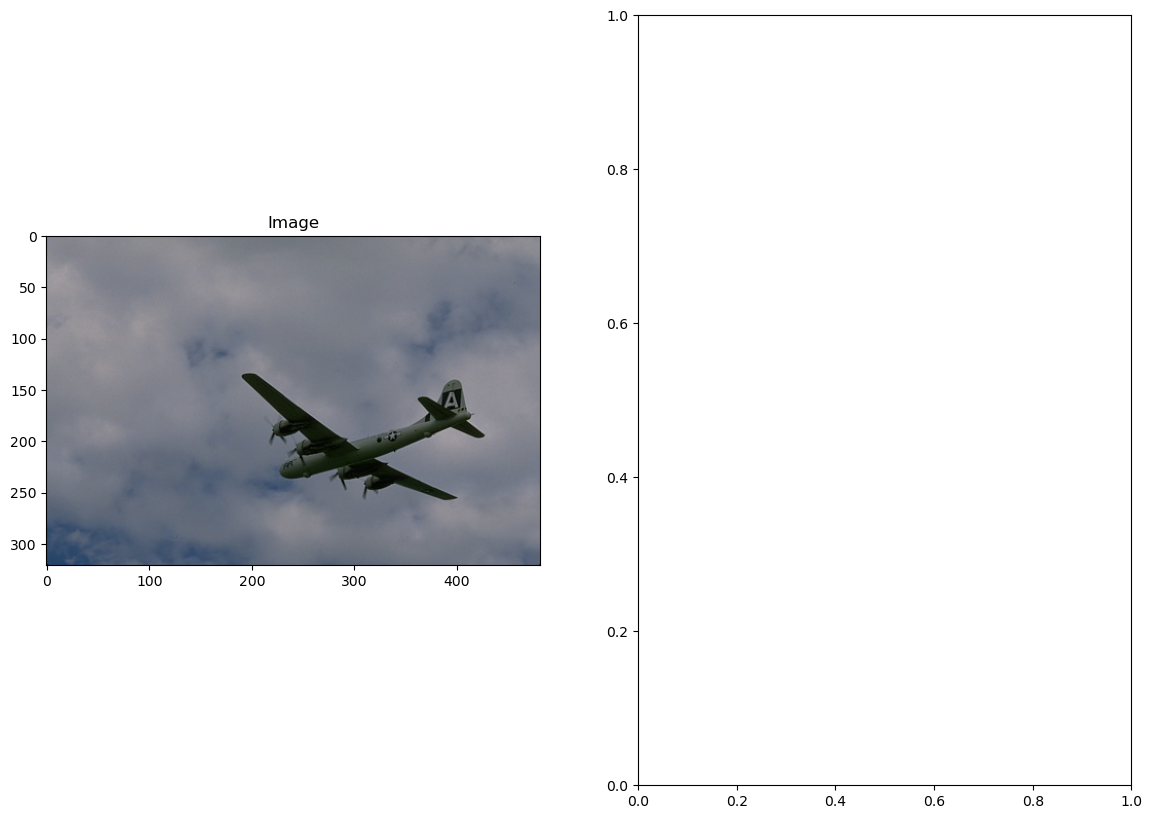

In [257]:
import imageio
path = ''
image_path = os.path.join(path, './image\\')
mask_path = os.path.join(path, './output-2\\')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')